In [1]:
import GMMfunction as GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace
from scipy.linalg import toeplitz
plt.rcParams["text.usetex"] = True
np.random.seed(30)
# import seaborn as sns
# sns.set_style('white')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

In [2]:
M, DX, DY, N, noise_level = (2, 3, 3, 10000, 2) # number of individual gaussians, dimension of the data, number of samples
mus = GMM.generate_mu_list(M, DX)
sigmas = GMM.generate_sigma_list(M, DX)
# mus = [np.array([1, 2]), np.array([8, 10])]
# sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
x = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, N).T

A = np.random.randn(DY, DX)
Nsigma, n = GMM.generate_noise(noise_level, DY, N)

y = A @ x + n

train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

(3, 2000)
(3, 2000)


Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

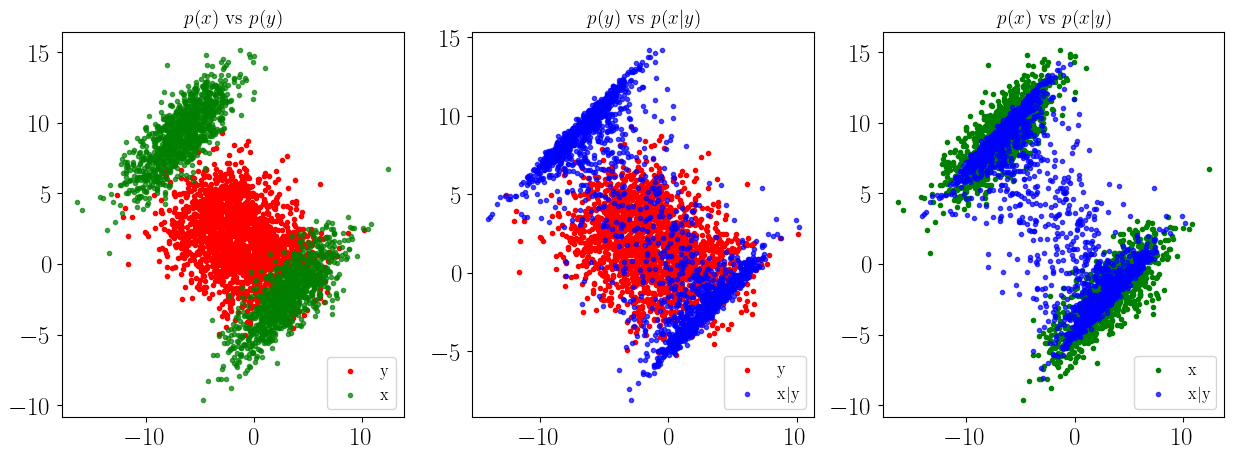

In [3]:

%matplotlib inline
mu1_real_res = GMM.mu1_real(test_samples_y, A, mus, sigmas, Nsigma)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)

In [ ]:
x_1 = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, 1).T
mmse = A @ x_1 + GMM.generate_noise(noise_level, DX, 1)[1]
bmmse = np.concatenate([mmse] * 2, axis=1)

[[ 0.0884581   0.0884581 ]
 [ 2.66858965  2.66858965]
 [10.46986655 10.46986655]]
[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


In [ ]:
n_ev = 2 # number of eigenvectors
x_1 = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, 1).T
y_1 = A @ x_1 + GMM.generate_noise(noise_level, DY, 1)[1]

first_moments, second_moments, eigvecs, eigvals, mmse = GMM.moment_calculation(y_1, A, mus, sigmas, Nsigma, n_ev)

plt.figure(figsize=(6,5))

[XX, YY] = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
xs = np.stack([XX.ravel(), YY.ravel()])

c = plt.imshow(GMM.px_pdf_real(xs, mus, sigmas).reshape(XX.shape), cmap='Blues', origin='lower', extent=[-20, 20, -20, 20], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

eigvecs /= np.linalg.norm(eigvecs, axis=0, keepdims=True)
eigvals = np.abs(eigvals)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

NameError: name 'D' is not defined